In [96]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [46]:
# params
sma_window = 5 # how many days to look back when calculating SMA
cluster_window = 50 # how many days to look back when clustering
window_offset = 10 # how many days to skip before starting a new loop

In [31]:
# Load data, sort and convert to row-wise timeseries
df = pd.read_csv("data/prices_sample.csv").sort_values("Date")
df = pd.pivot_table(df, index="Date", columns="Ticker", values="Close")
df = df.ffill().dropna(axis=1, how='any')
df = df.rolling(window=sma_window).mean().dropna(axis=0, how='any')
df = df.T

<Axes: xlabel='Date'>

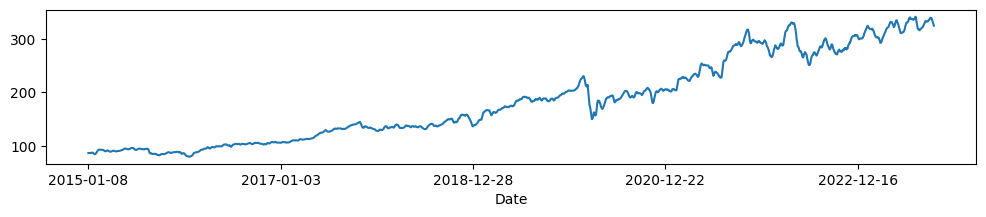

In [40]:
# visual inspection of data, we have to see the SMA(sma_window) of the price over time (not scaled, not truncated)
df.loc["AON"].plot(figsize=(12,2))

In [51]:
# create dataset for clustering with fixed lenght 
df_result = pd.DataFrame()
total_days = df.shape[1]

for i in tqdm(range(0, total_days - cluster_window, window_offset)):
    # get data from fixed lenght window
    tmp = df.iloc[:, i:i + cluster_window]
    
    # concat tmp to df_total as rows
    tmp.columns = range(cluster_window) # rename columns from 0 to cluster_window
    df_result = pd.concat([df_result, tmp], axis=0, ignore_index=True)

  0%|          | 0/215 [00:00<?, ?it/s]

<Axes: >

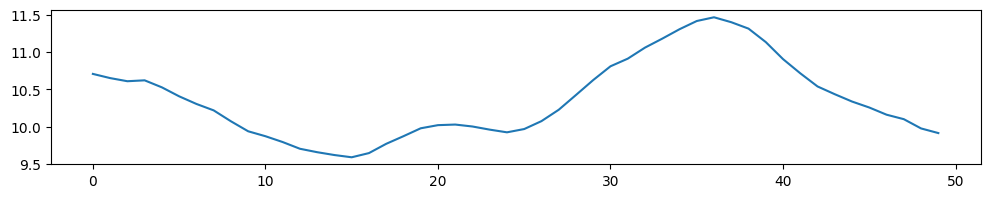

In [102]:
# visual inspection of data (This is SMA(sma_window), truncated but not yet scaled)
df_result.loc[5].plot(figsize=(12,2))

In [73]:
# scaling each row between 0 and 1
# !important to scale each row and not columns
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_result.T).T
df_scaled = pd.DataFrame(scaled, columns=df_result.columns) 


<Axes: title={'center': 'Data ready to be clustered'}>

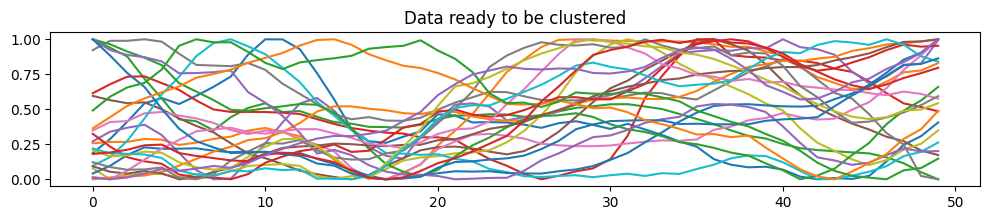

In [114]:
# visual inspection of data (This is SMA(sma_window), truncated and scaled) ready for clustering
df_scaled.iloc[:25].T.plot(figsize=(12,2), legend=False, title="Data ready to be clustered")

In [100]:
# Fit kmeans with different number of cluster
k_evaluated = []
X_range = range(10, 500, 1) 
for i in tqdm(X_range):
    kmeans = KMeans(n_init="auto", n_clusters=i)
    kmeans.fit(df_scaled)
    k_evaluated.append(kmeans.inertia_)

  0%|          | 0/490 [00:00<?, ?it/s]

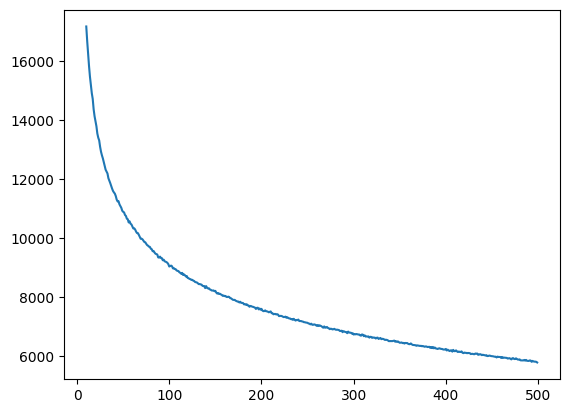

In [103]:
# plot elbow curve
plt.plot(X_range, k_evaluated)

In [110]:
# let's assume k=10 for the sake of simplicity, but the best k should be evaluated with the elbow curve (about k=100)
final_model = KMeans(n_init="auto", n_clusters=10).fit(df_scaled)
centroids = final_model.cluster_centers_

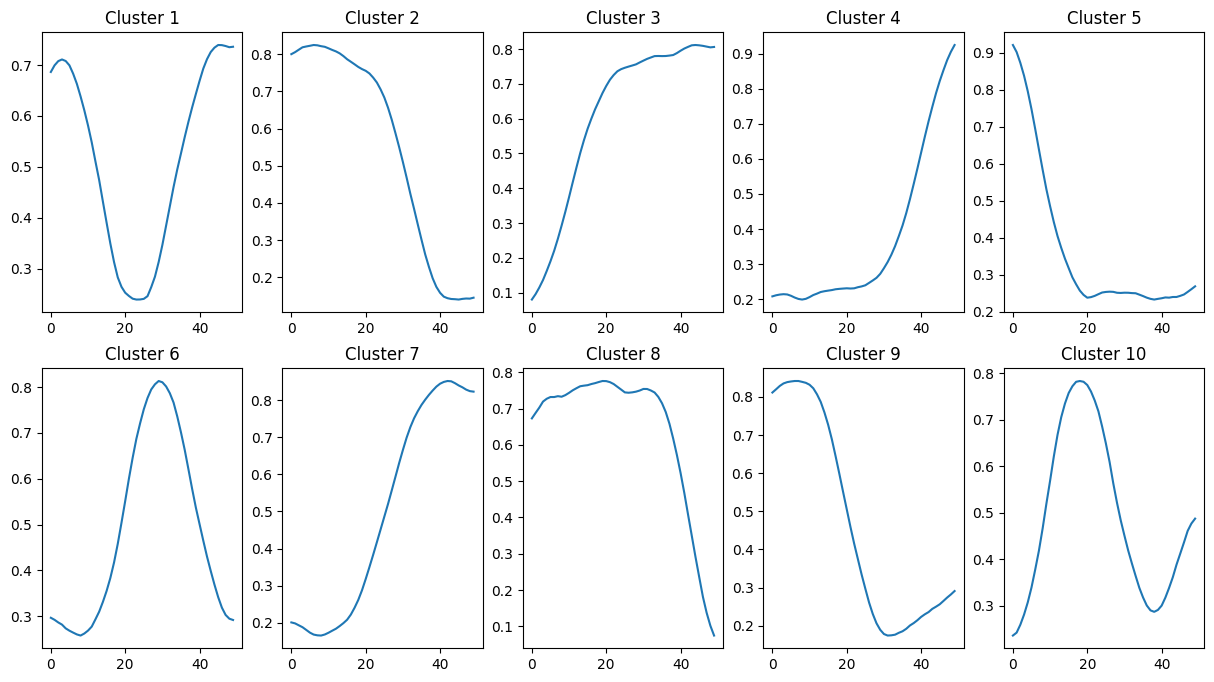

In [109]:
# plot 2x5 subplots with each centroid
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()
for i in range(10):
    ax[i].plot(centroids[i])
    ax[i].set_title("Cluster " + str(i+1))

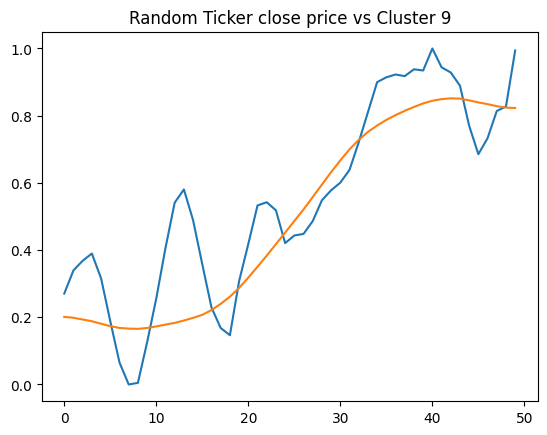

In [117]:
# Finally lets assign a sample to a cluster
sample = df_scaled.iloc[4]
cluster = final_model.predict([sample])

# plot the sample and the centroid of the cluster
plt.figure()
plt.plot(sample)
plt.plot(centroids[cluster[0]])
plt.title("Random Ticker close price vs Cluster " + str(cluster[0]+1))
plt.show()